In [1]:
from imports import *

In [2]:
def compute_eib(neurons, metadata, stru, binSize, start = 0, end = None,nbins=None,as_tsd = True):
    activity = bk.compute.binSpikes(neurons, binSize, start = start, stop = end, as_Tsd=as_tsd, nbins=nbins)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values, 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values, 1)
    eib = e_spikes / (e_spikes+i_spikes)
    eib = nts.Tsd(activity.times(), eib)

    return eib


In [3]:
# def compute_transition_activity(neurons, intervals, timing, bin_epochs, n_event):

#     transition_activity = []
#     for event, t in zip(intervals.iloc, timing):  # For each transitions
#         if n_event == 2:
#             epochs = np.array(
#                 [(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
#         if n_event == 3:
#             epochs = np.array(
#                 [[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
#         epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
#         # Creates intervals for each state of the transitions events.

#         #         binned = np.array(shape = (252,np.sum(bin_epochs)))
#         #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
#         binned = np.empty(shape=(len(neurons), 1))
#         for i, epoch in enumerate(epochs.as_units("s").iloc):
#             start = epoch.start
#             end = epoch.end
#             nbins = bin_epochs[i]
#             _, b = bk.compute.binSpikes(
#                 neurons, start=start, stop=end, nbins=nbins)
#             b = b / ((end - start) / nbins)  # Converting to firing rates
#             binned = np.hstack((binned, b))
#         binned = binned[:, 1:]
#         transition_activity.append(binned)

#     transition_activity = np.array(transition_activity)
#     transition_activity = np.moveaxis(transition_activity, 0, 2)

#     return transition_activity

In [4]:
def compute_average_at_transitions(tsd,intervals,timing,bin_epochs,n_event):
    transition_activity = []
    all_binned = []
    for event, t in zip(intervals.iloc, timing):  # For each transitions
        if n_event == 2:
            epochs = np.array([(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
        if n_event == 3:
            epochs = np.array([[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
        epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
        binned = []
        for i, epoch in enumerate(epochs.iloc):
            start = epoch.start
            end = epoch.end
            inter = nts.IntervalSet(start,end)
            nbins = bin_epochs[i]
            tsd_ = tsd.restrict(inter)
            tsd_ = scipy.signal.resample(tsd_.values,nbins)
            binned.append(tsd_)
        binned = np.hstack(binned)
        if not np.isnan(np.mean(binned)):
            all_binned.append(binned)
    return np.vstack(all_binned)


In [5]:
def compute_average_at_transitions(neurons,metadata,intervals,timing,stru,bin_epochs,n_event):
    
    states = bk.load.states(True)
    baseline_intervals = states['REM'].union(states['NREM']).union(states['WAKE_HOMECAGE'])
    baseline_eib = compute_eib(neurons,metadata,'BLA',binSize=0.1,as_tsd=True).restrict(baseline_intervals)
    baseline_mean = np.nanmean(baseline_eib.values)
    baseline_std = np.nanstd(baseline_eib.values)
    
    transition_activity = []
    all_binned = []
    for event, t in zip(intervals.iloc, timing):  # For each transitions
        if n_event == 2:
            epochs = np.array([(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
        if n_event == 3:
            epochs = np.array([[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
        epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
        binned = []
        for i, epoch in enumerate(epochs.as_units('s').iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            eib_ = compute_eib(neurons,metadata,stru,10,start,end,nbins)
            eib_ = nts.Tsd(eib_.index.values,(eib_.values-baseline_mean)/baseline_std)
            # eib_ = compute_eib(neurons,metadata,'BLA',0.100,0,None,nbins)
            binned.append(eib_)
        binned = np.hstack(binned)
        if not np.isnan(np.mean(binned)):
            all_binned.append(binned)
    return np.vstack(all_binned)


In [46]:
def main(base_folder,local_path,*args,**kwargs):

    transition_interest = kwargs['transition_interest']
    bin_epochs = kwargs['bin_epochs']
    n_event = kwargs['n_event']
    epsilon = kwargs['min_duration']
    stru = kwargs['stru']


    bk.load.current_session_linux(base_folder,local_path)
    neurons, metadata = bk.load.spikes()

    if np.sum((metadata.Region == 'BLA') & (metadata.Type == 'Int')) <3:
        raise IndexError('Less than 5 interneurons')

    states = bk.load.states(True)
    states['WAKE_HOMECAGE'] = states['WAKE_HOMECAGE'].union(states['drowsy'])
    states.pop('drowsy')


    transition_activity = {}
    for i, transition_name in enumerate(transition_interest):  # For each kind of transitions
        print(f"Computing {'-'.join(transition_name)} transitions")
        print(transition_name[0])
        intervals, timing = bk.compute.transition(states, transition_name, epsilon=[epsilon[transition_name[0]],epsilon[transition_name[1]]])  # Find the timing of the transitions
        if intervals is False: 
            transition_activity['-'.join(transition_name)] = None
            continue
        print(f"Found {len(intervals)} transitions")
        # transition_activity['-'.join(transition_name)] = compute_average_at_transitions(eib,intervals,timing,bin_epochs[i],n_event[i])
        transition_activity['-'.join(transition_name)] = compute_average_at_transitions(neurons,metadata,intervals,timing,stru,bin_epochs[i],n_event[i])

        # transition_activity = compute_transition_activity(neurons,intervals,timing,bin_epochs[i],n_event[i])
    transitions_names = ['-'.join(names) for names in transition_interest]
    bin_epochs = dict(zip(transitions_names,bin_epochs))
    return transition_activity,bin_epochs


def merge(batch,transition_name):
    all_eib = []
    for sess,b in batch.items():
        # plt.subplots()
        # plt.plot(b.T)
        # plt.title(sess)
        if b[0][transition_name] is not None:
            all_eib.append(np.vstack(b[0][transition_name]))
            bins_epochs = b[1]
        else:
            a = np.empty(np.sum(b[1][transition_name]))
            a.fill(np.nan)
            all_eib.append(a)
    return np.vstack(all_eib),bins_epochs[transition_name]

def plot(batch_data,transition_name,ax_im,ax):
    all_eib,bins = merge(batch_data,transition_name)
    ax_im.imshow(zscore(all_eib,1),aspect = 'auto')
    ax_im.set_title(transition_name)
    bk.plot.confidence_intervals(range(all_eib.shape[1]),all_eib,ax=ax)
    # bk.plot.curve_and_shades(range(all_eib.shape[1]),all_eib,'sem',ax=ax)
    plt.sca(ax)
    plt.axvspan(bins[0],bins[0]+bins[-1]-1,color = 'grey',alpha = 0.5)

    ax_im.set_ylabel('Session #')
    ax.set_ylabel(('EIB'))
    ax.set_xlabel('Time Norm')



In [47]:
kwargs = {'transition_interest': [['REM', 'WAKE_HOMECAGE'],['NREM','REM'],['REM','NREM'],['WAKE_HOMECAGE','NREM'],['NREM','WAKE_HOMECAGE']],
          'bin_epochs': [[12, 30],[30, 12],[12, 30],[30,30],[30,30]],
          'n_event':[2,2,2,2,2],
          'stru':'BLA',
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },}
bk.load.current_session_linux()
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch_data,batch_metadata = bk.load.batch(main,**kwargs)

100%|██████████| 61/61 [03:40<00:00,  3.61s/it]

Batch finished in 220.00864839553833
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %


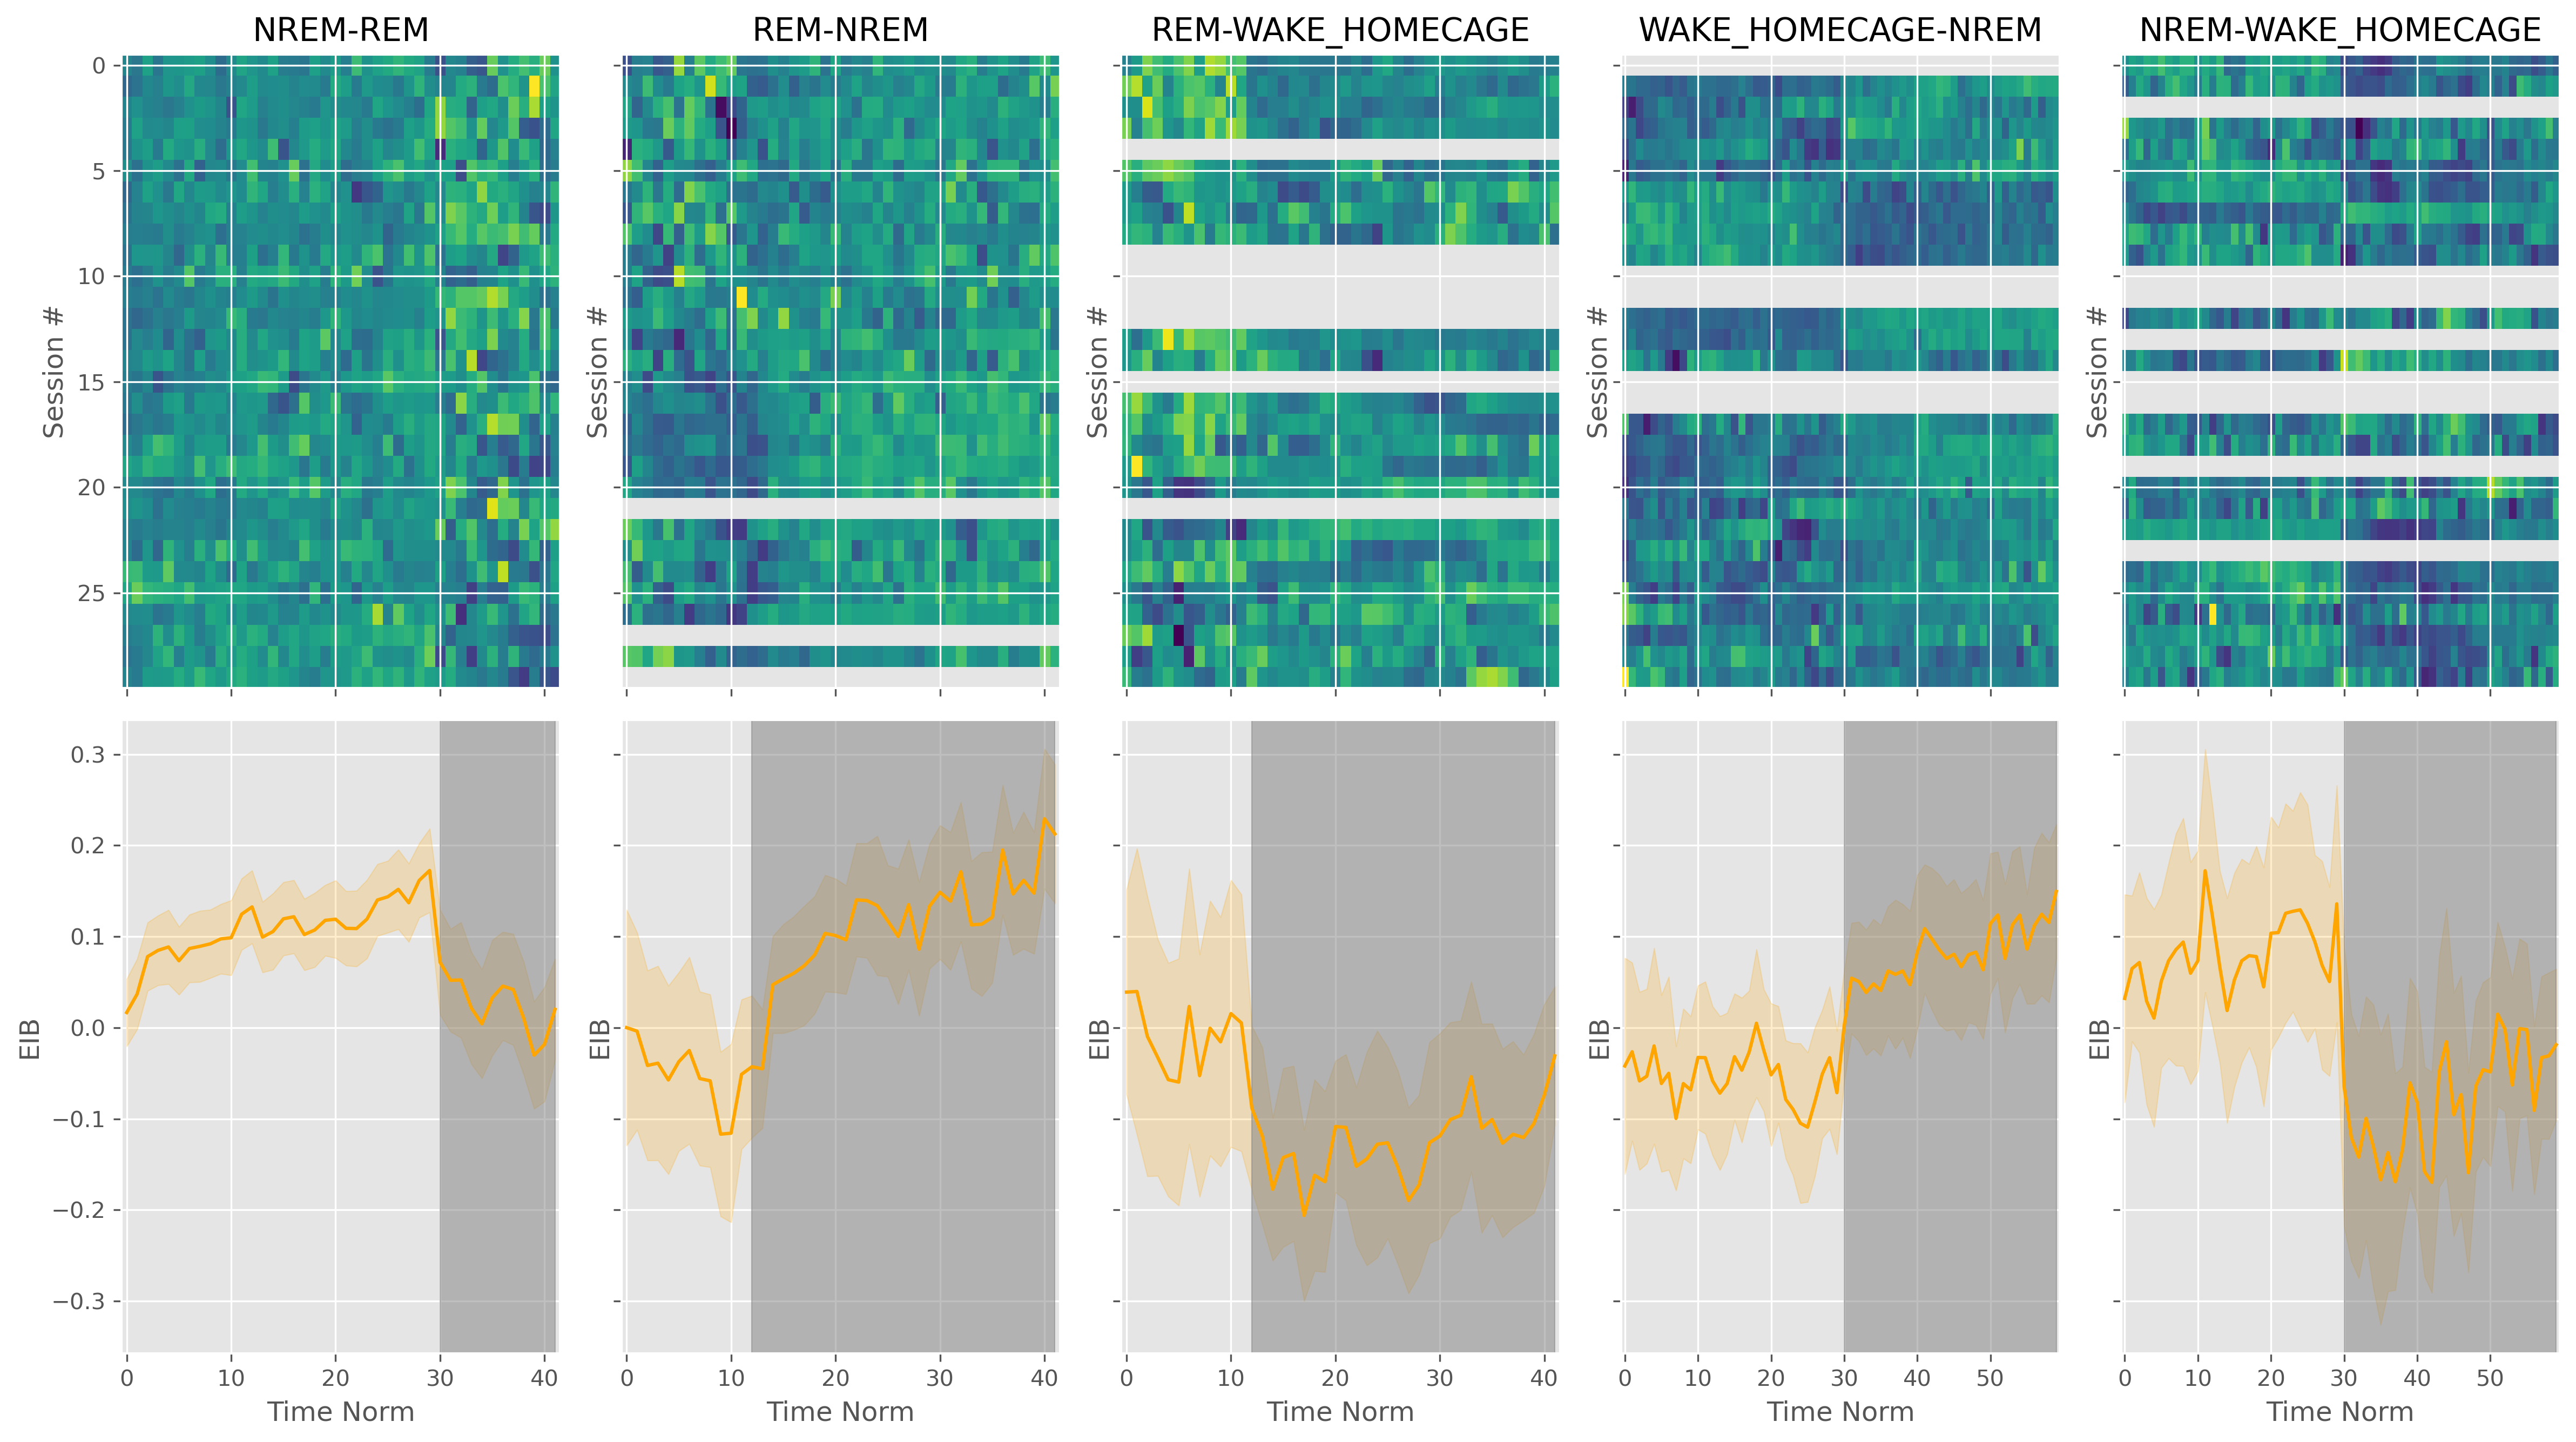

In [49]:
names = ['NREM-REM','REM-NREM','REM-WAKE_HOMECAGE','WAKE_HOMECAGE-NREM','NREM-WAKE_HOMECAGE']
fig,ax = plt.subplots(2,5,dpi = 300,figsize = (16,9),sharex = 'col',sharey = 'row')
for i,name in enumerate(names):
    plot(batch_data,name,ax[0,i],ax[1,i])
    # ax[0,i].set_ylim(200,0)
plt.tight_layout()

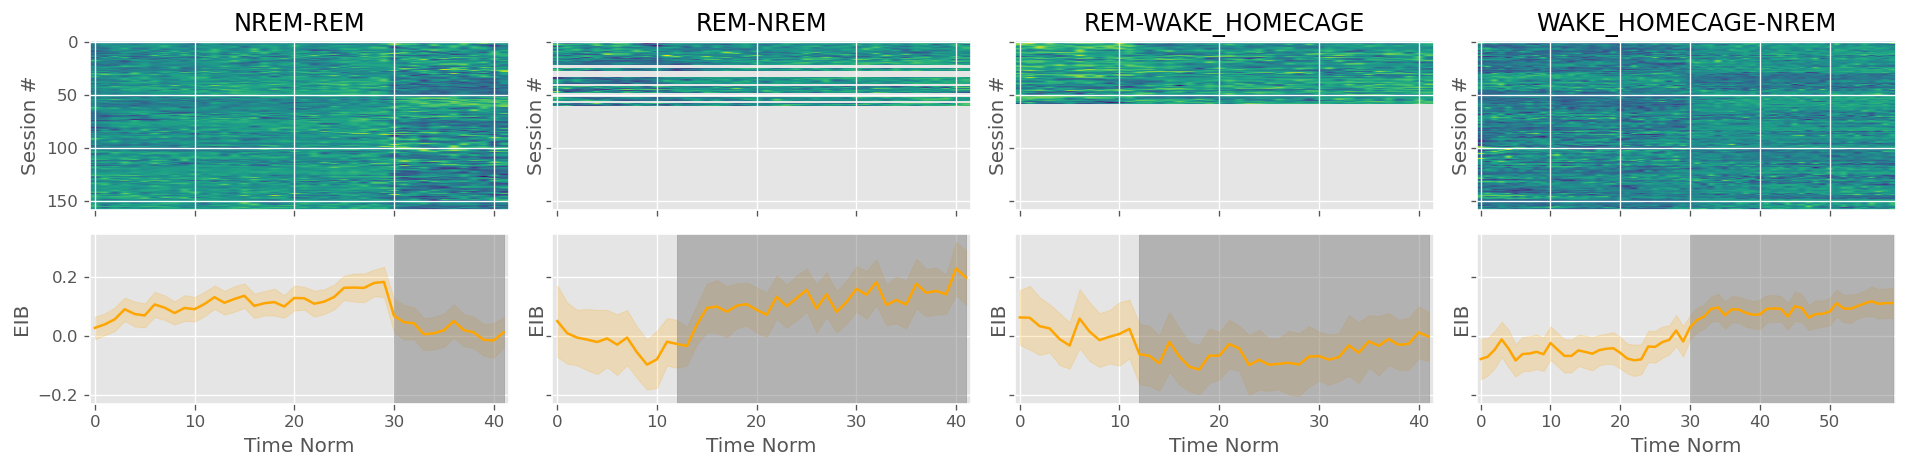

In [29]:
names = ['NREM-REM','REM-NREM','REM-WAKE_HOMECAGE','WAKE_HOMECAGE-NREM']
fig,ax = plt.subplots(2,4,dpi = 120,figsize = (16,4),sharex = 'col',sharey = 'row')
for i,name in enumerate(names):
    plot(batch_data,name,ax[0,i],ax[1,i])
plt.tight_layout()

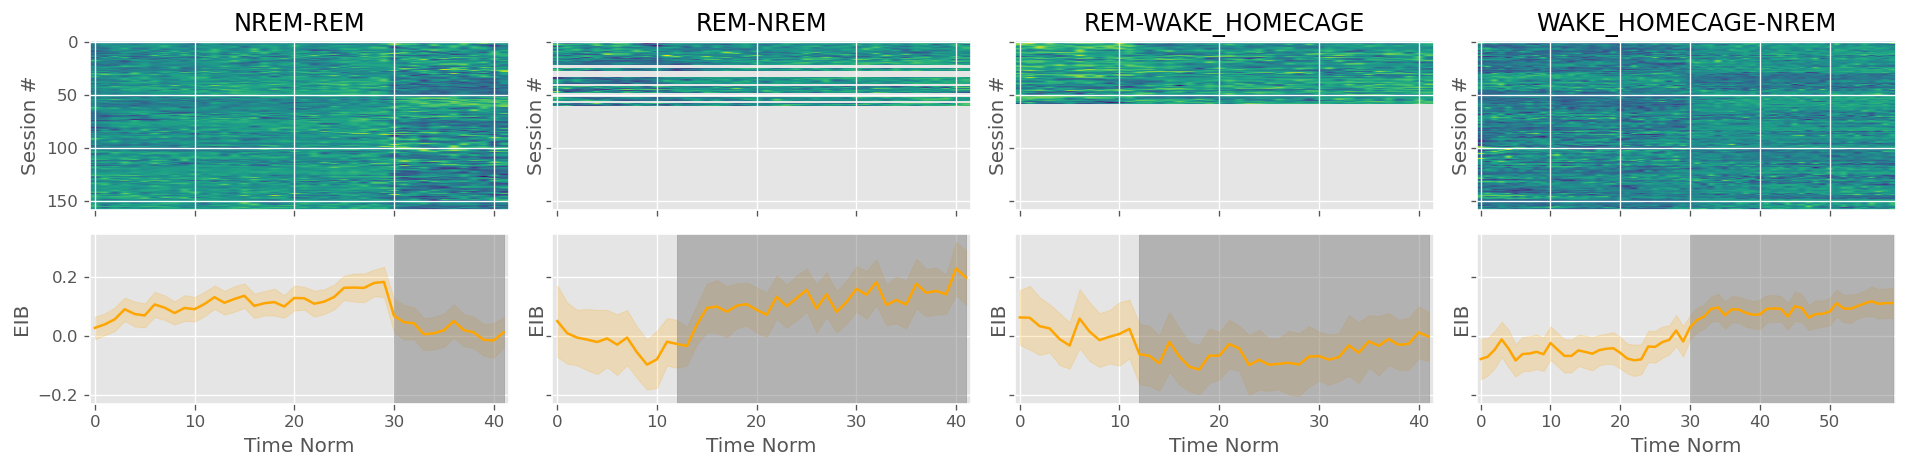

In [30]:
names = ['NREM-REM','REM-NREM','REM-WAKE_HOMECAGE','WAKE_HOMECAGE-NREM']
fig,ax = plt.subplots(2,4,dpi = 120,figsize = (16,4),sharex = 'col',sharey = 'row')
for i,name in enumerate(names):
    plot(batch_data,name,ax[0,i],ax[1,i])
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/transition_eib.svg')

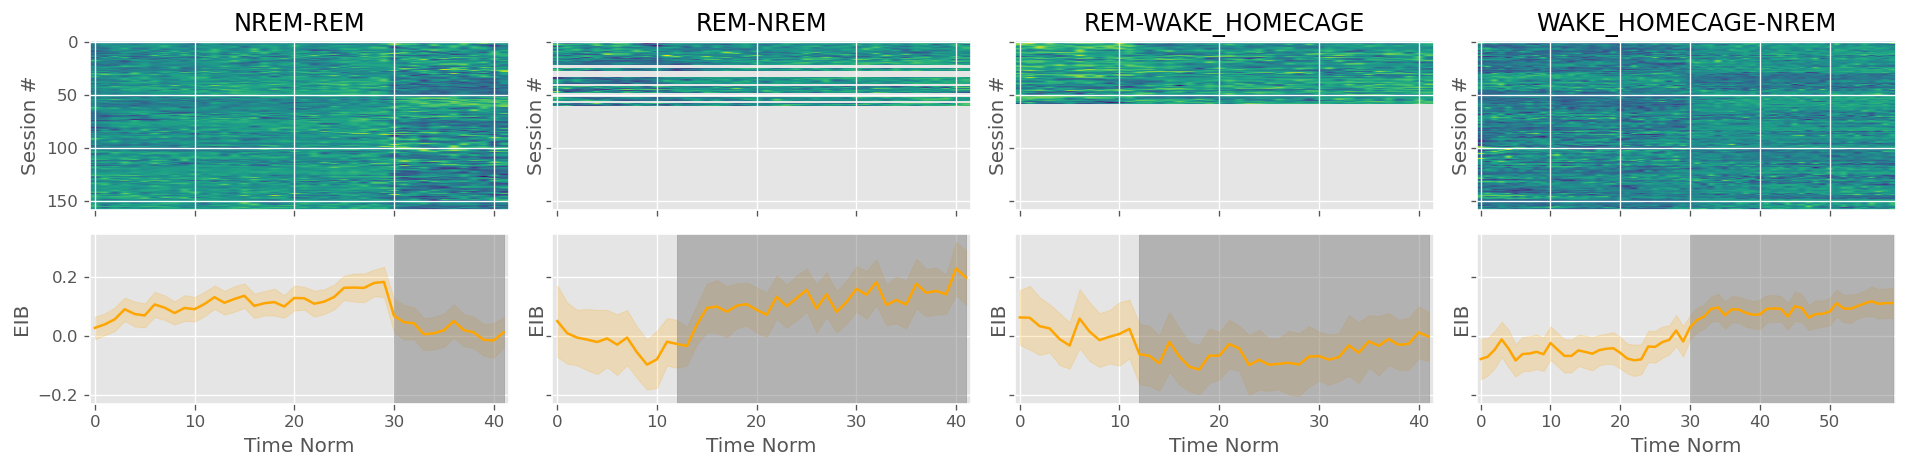

In [8]:
names = ['NREM-REM','REM-NREM','REM-WAKE_HOMECAGE','WAKE_HOMECAGE-NREM']
fig,ax = plt.subplots(2,4,dpi = 120,figsize = (16,4),sharex = 'col',sharey = 'row')
for i,name in enumerate(names):
    plot(batch_data,name,ax[0,i],ax[1,i])
plt.tight_layout()

In [17]:
all_eib,bins = merge(batch_data,'NREM-REM')